The corrected mass distributions for each component are not analytic functions. Therefore to fit this variable we use binned template fits. Each component is described by a histogram. The likelihood of the fit is then the product of the Poisson probabilities from each bin of the histogram. The expected rate in each bin is the sum of the yield of each component in that bin. Each fit component has an overall scaling factor, that is a free parameter in the fit.

Here we use a combination of [cabinetry](https://cabinetry.readthedocs.io/en/latest/) and [pyhf](https://pyhf.github.io/pyhf-tutorial/introduction.html) to set up a simple fit in corrected mass.

In [296]:
import pyhf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
from cabinetry.model_utils import prediction
from pyhf.contrib.utils import download
import json
import cabinetry

The fit is set up using the markdown file `config.yaml`. You can see the full schema of the configuration [here](https://cabinetry.readthedocs.io/en/latest/config.html)

Under the `Region` section you can set up what variable of your tuples to fit, $m_{\mathrm{corr}}$, and how to bin that variable. In the `Filter` field you can set some cuts - for example on $q^{2}$. In this example we cut on the muon PID, `mu_ProbNNmu`, to try and reduce background.

Under `Samples` you add the data sample you want to fit and then each fit component. For all of them you give it them name of the file with the tuple and the name of `TTree` inside. For each sample you can also set the `Filter` property to apply a selection. Furthermore you have the option to point it to a branch containing weights for that particular component, i.e. if there are data/MC corrections or physics weighting.

Finally under `NormFactors` you provide the normalisation factors for each of the components. These are the fit parameters that will be estimated.

In [424]:
# First, get cabinetry to read the configuration
cabinetry_config = cabinetry.configuration.load("config.yaml")

In [425]:
# Now we have read the config we can get cabinetry to load up the fit templates from all of the tuples
cabinetry.templates.build(cabinetry_config, method="uproot")
cabinetry.templates.postprocess(cabinetry_config)

In [427]:
# Make a workspace to save useful things in
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

sample_list = []
# Divide each template by the sum of events in them so make the fitted normalisation factor
# The component yields
for _c in range(len(ws['channels'][0]['samples'])):
    sample_list.append(ws['channels'][0]['samples'][_c]['name'])
    normfactor = np.sum(ws['channels'][0]['samples'][_c]['data'])
    ws['channels'][0]['samples'][_c]['data'] /= normfactor
    ws['channels'][0]['samples'][_c]['data'] = ws['channels'][0]['samples'][_c]['data'].tolist()
    ws['channels'][0]['samples'][_c]['modifiers'][0]['data'] /= normfactor
    ws['channels'][0]['samples'][_c]['modifiers'][0]['data'] = ws['channels'][0]['samples'][_c]['modifiers'][0]['data'].tolist()

In [428]:
# Let's make a toy data set from our expected model that we loaded from the config
toyFit = True
model, data = cabinetry.model_utils.model_and_data(ws, asimov = toyFit)
# Now add some Poisson variation to our toy data
if toyFit:
    data[:6] = np.random.poisson(data[:6])    

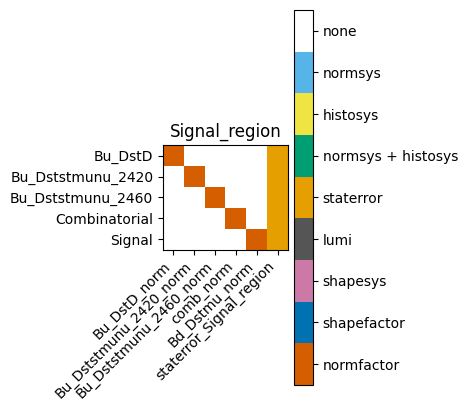

In [429]:
# If we have multiple regions to fit where fit parameters are shared we can visualise the crossover.
# This is particularly useful for complicated fits with several control regions that are used to 
# help model the backgrounds
cabinetry.visualize.modifier_grid(model)
# From this model we can see there is 1 region and 5 fit components. Each component has a normalisation factor.
# Not as well the statistical error parameter - this is a per-bin parameter to deal with the statistical uncertainties
# of the fit templates

In [430]:
# Now do a fit of the model to the toy data
fit_results = cabinetry.fit.fit(model, data)

W MnPosDef Matrix forced pos-def by adding to diagonal 0.00664023
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00808123


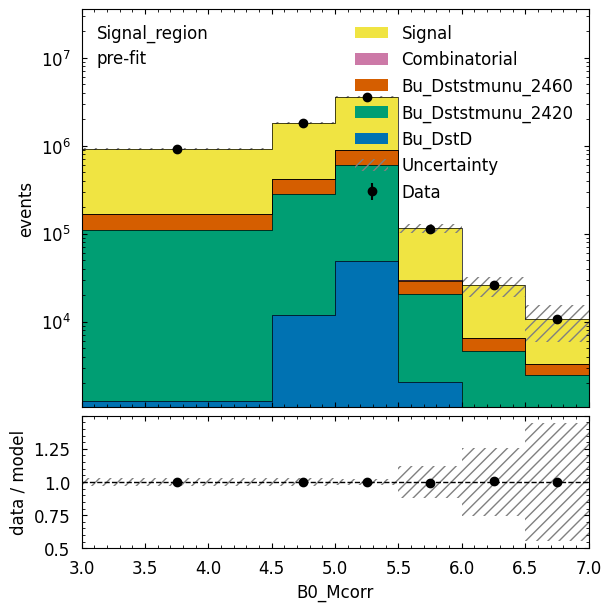

In [431]:
# Visualise the components and data before the fit is done:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

It is a good fit


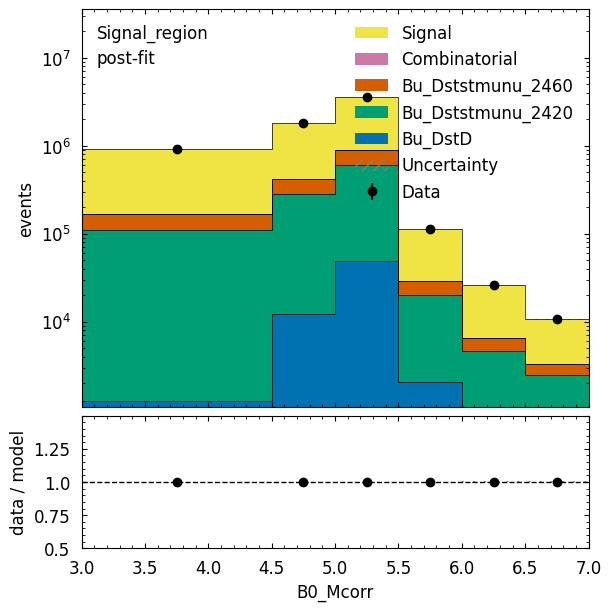

In [432]:
# Visualise the fit and components after the fit is done
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=cabinetry_config)
print("It is a good fit")

/tmp/ipykernel_15890/460614118.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


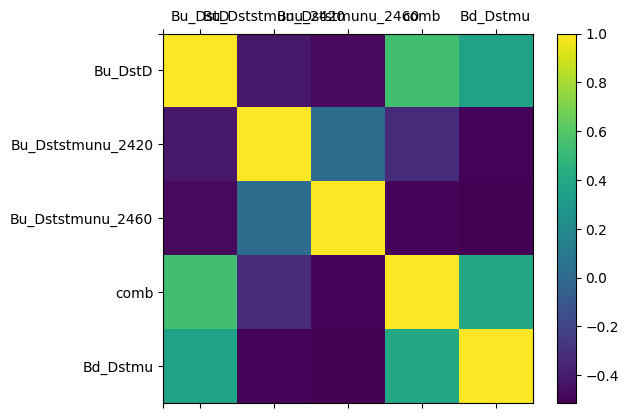

In [433]:
# Now plot the matrix to see how correlated the individual fit components are
ticklabels = [_l.strip('_norm') for _l in fit_results.labels[:5]]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fit_results.corr_mat[:5,:5], interpolation='nearest')
fig.colorbar(cax)
ax.set_xticks([-0.5,0,1,2,3,4])
ax.set_yticks([-0.5,0,1,2,3,4])
ax.set_xticklabels([' '] + ticklabels)
ax.set_yticklabels([' '] + ticklabels)
fig.show()

Text(0, 0.5, '$\\frac{fit - init}{\\sigma}$')

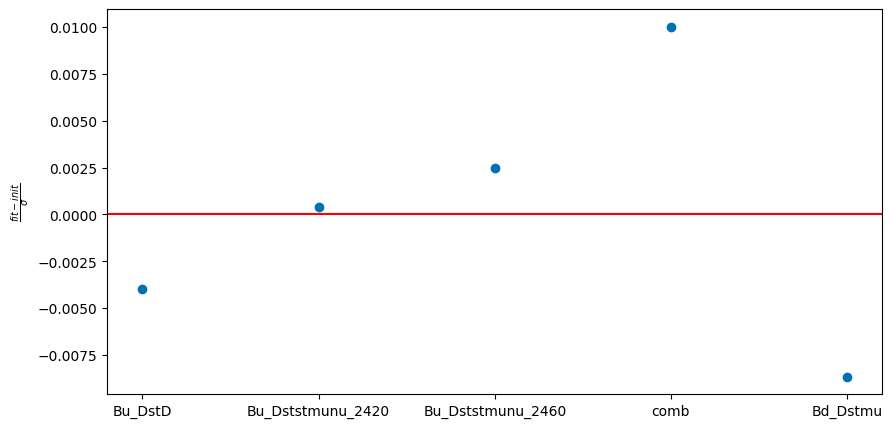

In [434]:
# What is the pull on the yields of the various fit components?
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(np.arange(5),(fit_results.bestfit[:5] - model.config.suggested_init()[:5])/fit_results.uncertainty[:5],
         ls = "None", marker = "o")
plt.axhline(0, color = "red")
ax.set_xticks(np.arange(5), ticklabels)
ax.set_ylabel(r"$\frac{fit - init}{\sigma}$")

In [435]:
# So what is the fit result?
print("INFO:  The fitted signal yield is %.2f +/- %.2f" % (fit_results.bestfit[4], fit_results.uncertainty[4]))

INFO:  The fitted signal yield is 4937861.58 +/- 21208.90


Let's take a closer look at the fit results. The `fit_results.bestfit` and `fit_results.uncertainty` objects are both arrays of length 11 - the number of fit components + the number of bins.

The first 5 numbers are the best fit values and uncertainties of the yields of the fit components. The last 6 components are the per-bin scaling factors that take care of the statistical uncertainty of the bin templates. We could turn these off with the `DisableStaterror` option in the config.

In [436]:
print("Fit results: \n", fit_results.bestfit)
print("\nFit uncertainties: \n", fit_results.uncertainty)

Fit results: 
 [6.57555361e+04 9.52037036e+05 5.02091664e+05 9.26463717e+03
 4.93786158e+06 9.99193603e-01 1.00026717e+00 1.00020197e+00
 9.93265525e-01 1.00776662e+00 9.97515777e-01]

Fit uncertainties: 
 [1.27539627e+04 2.31256793e+04 2.60330366e+04 1.20748028e+04
 2.12089017e+04 3.08105902e-03 3.18801293e-03 4.00428091e-03
 5.55249019e-03 7.63121342e-03 1.74772942e-02]
